In [100]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import cv2
try:
    from imutils import paths
except:
    !pip install imutils --quiet
    from imutils import paths
try:
    import timm
except:
    !pip install timm --quiet
    import timm
import json
import time, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as ans
from tqdm import tqdm
import shutil
import gdown
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import tensorflow_datasets as tfds
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import *
from datetime import datetime
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense, Input, UpSampling2D, Conv2DTranspose, Conv2D, add, Add,\
                    Lambda, Concatenate, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, \
                    Add, LayerNormalization, Activation, LeakyReLU, SeparableConv2D, Softmax, MaxPooling2D, Dropout




In [23]:
!git clone https://github.com/shilu10/CaiT-TF2.git

rm: cannot remove 'CaiT2': No such file or directory
rm: cannot remove 'CaiT3': No such file or directory
rm: cannot remove 'CaiT4': No such file or directory
fatal: destination path 'CaiT-TF2' already exists and is not an empty directory.
mv: missing destination file operand after 'CaiT-TF2'
Try 'mv --help' for more information.


In [ ]:
# to port weights from pretrained pytorch to tensorflow model
#from CaiT.port_all import main
#main()


# download cait models from gdrive
url = "https://drive.google.com/uc?id=1vwKgaJf4VqCbKkUHsOIVOE2HBHUFv05I"
gdown.download(url)

In [ ]:
with open("/content/CaiT12/imagenet1k_eval/imagenet_labels.json", "r") as file:
  class_labels = json.load(file)

In [103]:
def get_reverse_class_labels(class_labels):
  reverse_class_labels_dict = {}
  for key, value in class_labels.items():
    for cls in value.split(","):
      reverse_class_labels_dict[cls.strip()] = int(key)

  return reverse_class_labels_dict

In [113]:
image_size = 224

In [114]:
# classification
crop_layer = keras.layers.CenterCrop(image_size, image_size)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)


def preprocess_image(image, size=image_size):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image_resized = tf.expand_dims(image, 0)
    #resize_size = int((256 / image_size) * size)
    image_resized = tf.image.resize(
        image_resized, (224, 224), method="bicubic"
    )
  #  image_resized = crop_layer(image_resized)
    return image_resized

def load_image_from_url(url):
    raw = tf.io.read_file(url)
    image = tf.image.decode_jpeg(raw)
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image

In [115]:
img_url = "CaiT-TF2/images/cait_lion.jpeg"
image, preprocessed_image = load_image_from_url(img_url)

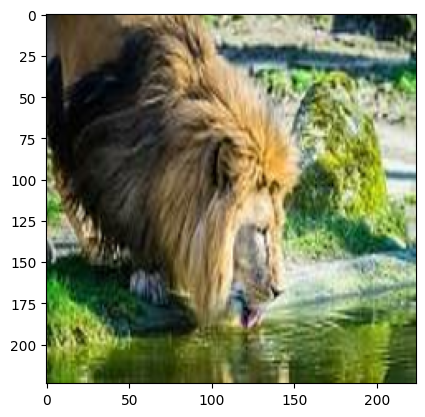

In [116]:
plt.imshow(preprocessed_image[0])

In [117]:
preprocessed_image.shape

TensorShape([1, 224, 224, 3])

In [ ]:
with open("imagenet1k_eval/imagenet_labels.json", "r") as file:
  class_labels = json.load(file)

model = keras.models.load_model("models/cait_xxs24_224", compile=False)

In [118]:
# predictions

predictions, sa_scores, ca_scores = model.predict(preprocessed_image)

1/1 [==============================] - 4s 4s/step


In [119]:
predictions = np.argmax(predictions)

In [120]:
class_labels[str(predictions)]

'lion, king of beasts, Panthera leo'

In [122]:
ca_scores.keys()

dict_keys(['class_attention_transformerb_1', 'class_attention_transformerb_0'])

In [123]:
# Reference:
# https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

patch_size = 16


def get_cls_attention_map(
    attn_score_dict=ca_scores,
    block_key="class_attention_transformerb_0",
    return_saliency=False,
) -> np.ndarray:
    """
    Returns attention scores from a particular attention block.

    Args:
        attn_score_dict: dict where the attention layer names are keys and corresponding
            attention scores are values.
        block_key: name of the attention block which we want to visualize.
        return_saliency: a boolean flag if set to True also returns the salient
            representations of the attention block.
    """
    w_featmap = preprocessed_image.shape[2] // patch_size
    h_featmap = preprocessed_image.shape[1] // patch_size

    attention_scores = attn_score_dict[block_key]
    nh = attention_scores.shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, 1:].reshape(nh, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    if not return_saliency:
        attentions = attentions.transpose((1, 2, 0))

    else:
        attentions = np.mean(attentions, axis=0)
        attentions = (attentions - attentions.min()) / (
            attentions.max() - attentions.min()
        )
        attentions = np.expand_dims(attentions, -1)

    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = tf.image.resize(
        attentions,
        size=(h_featmap * patch_size, w_featmap * patch_size),
        method="bicubic",
    )

    return attentions

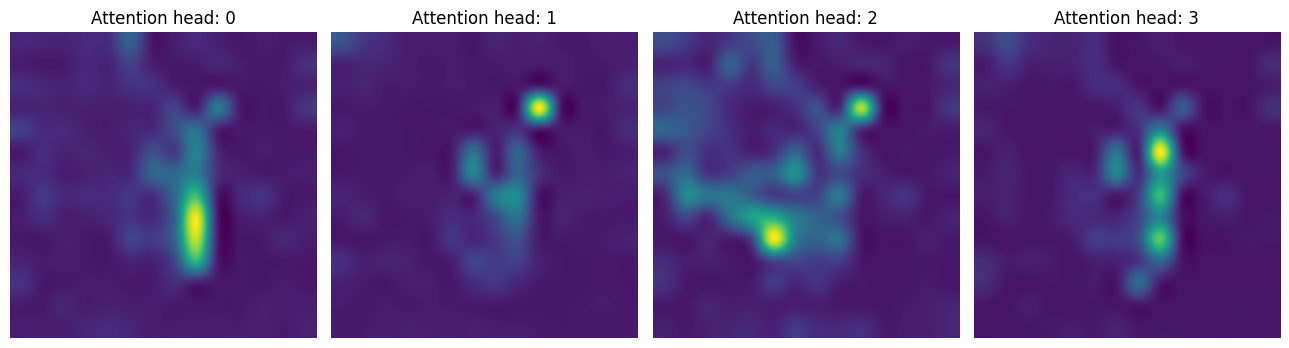

In [129]:
attentions_ca_block_0 = get_cls_attention_map()


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_0.shape[-1]):
    if img_count < attentions_ca_block_0.shape[-1]:
        axes[i].imshow(attentions_ca_block_0[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.savefig("attention_map_ca_block0.jpg")
plt.show()

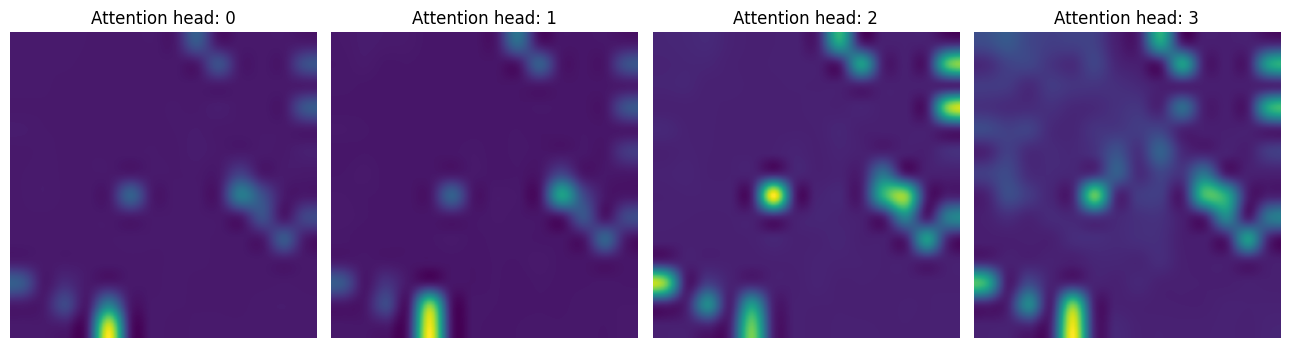

In [132]:
attentions_ca_block_1 = get_cls_attention_map(block_key="class_attention_transformerb_1")


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_1.shape[-1]):
    if img_count < attentions_ca_block_1.shape[-1]:
        axes[i].imshow(attentions_ca_block_1[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.savefig("attention_map_ca_block1.jpg")

plt.show()

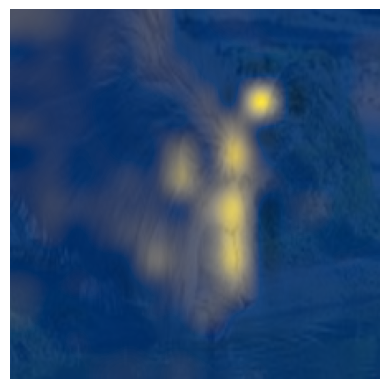

In [131]:
# saliency map
saliency_attention = get_cls_attention_map(return_saliency=True)

image = np.array(image)
image_resized = tf.expand_dims(image, 0)
resize_size = int((256 / 224) * image_size)
image_resized = tf.image.resize(
    image_resized, (resize_size, resize_size), method="bicubic"
)
image_resized = crop_layer(image_resized)

plt.imshow(image_resized.numpy().squeeze().astype("int32"))
plt.imshow(saliency_attention.numpy().squeeze(), cmap="cividis", alpha=0.9)
plt.axis("off")

plt.savefig("cait_lion_saliency_map.jpg")
plt.show()